In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.job_output import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values

RuntimeError: KeyboardInterrupt: 

# 11.7.4 MNIST LeNet rotatedtasks finetune

**RERUN 11.7.3**: use less samples for finetuning = **50**

- This is the follow up experiment for my PhD Talk
- Sweep over number of pretraining steps on rotation 0 (with 48k samples)
- Finetune rotations between 0°-180° (linspace(0,180,30,endpoint=True)) with limited number of samples (50)

Make the following investigations:
1. Plot pre-train length (x-axis) vs. val-accuracy (y-axis) for different rotations
2. Check linear mode connectivity of fine-tuning runs for different rotations

## A. Experiment config

### Config file

In [2]:
config_yaml = """
run_config:
  exec_type: parallel # sequential
  hostname: wasp
  gpu_ids: [0,1,2,3,4]
  runs_per_gpu: 5

  wandb: # wandb config for run_handler, if "wandb: null" then logging to wandb is disabled for run_handler
    init:
      tags:
        - ${config.experiment_data.experiment_tag}_exps
        - run_handler
      notes: #
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [1,2]

sweep:
  type: grid
  axes:
    - parameter: trainer.init_model_step
      vals: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
    - parameter: data.dataset_kwargs.rotation_angle
      vals: linspace(0,180,30,endpoint=True)
    - parameter: data.dataset_split.restrict_n_samples_train_task
      vals: [50] #[5, 20, 50, 100, 500, 1000, 10000, 48000]

start_num: 4 # use this to count how often this config is run
###
config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: sparsity
    experiment_tag: "11.7"
    experiment_type: startnum_${start_num}
    experiment_name: mnist-${config.experiment_data.experiment_tag}.${start_num}-lenet_rottasks_ft
    experiment_dir: null
    experiment_notes: Hyperparameter search.
    job_name: null
    seed: 0
    hostname: null # the server on which the run is run, will be filled by run_handler
    gpu_id: 0

  # wandb:
  #   init:
  #     tags: # list(), used to tag wandblogger
  #       - ${config.experiment_data.experiment_tag}_exps
  #     notes: ${config.experiment_data.experiment_notes} # str, used to make notes to wandblogger
  #     group: ${config.experiment_data.experiment_tag} # null
  #     job_type: ${config.experiment_data.experiment_type} # examples: hypsearch, pretrain, eval, etc.

  #   watch:
  #     log: null #parameters #null #all
  #     log_freq: 5000

  model:
    name: fc
    model_kwargs:
      input_size: 784
      hidden_sizes:
        - 300
        - 100
      output_size: 10
      flatten_input: True
      dropout: null
      act_fn: relu

  trainer:
    training_setup: supervised
    n_steps: 2000
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: True
    val_every: 5
    save_every: 5 #500
    early_stopping_patience: 200 #500
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: adamw #sgd #adamw
      optimizer_kwargs:
        lr: 0.001
        weight_decay: 0.0
    
    init_model_step: XXX
    init_model: /system/user/beck/pwbeck/projects/regularization/erank/outputs/mnist-11.5.0-lenet--221015_122552/model_step_${config.trainer.init_model_step}.p

    loss: crossentropy

    metrics:
      - Accuracy
    num_workers: 4
    verbose: False

  data:
    dataset: rotatedvision
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
      dataset: mnist
      rotation_angle: XXX
    dataset_split:
      train_val_split: 0.8
      restrict_n_samples_train_task: XXX

"""
cfg = OmegaConf.create(config_yaml)

In [3]:
# run_command = REPO.create_experiment(cfg, override=False)
# print(run_command)

### Sweep result

In [4]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

Exp. Tag(start_num): 11.7(4)
Exp. Name: mnist-11.7.4-lenet_rottasks_ft
Training setup: supervised
Model name: fc
Dataset name: rotatedvision
Sweep type: grid
  trainer.init_model_step: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
  data.dataset_kwargs.rotation_angle: linspace(0,180,30,endpoint=True)
  data.dataset_split.restrict_n_samples_train_task: [50]
Num. jobs: 2150
Config updated: 2022-12-12 17:43:28
Sweep started:  2022-12-12 17:42:56



### Helper variables from config

In [5]:
# some important variables from config
pretrain_run = JobResult(job_dir=Path(cfg.config.trainer.init_model).parent)

In [6]:
pretrain_run.get_summary()

,best_step,best_val_score,seed
mnist-11.5.0-lenet--221015_122552,430,0.96075,0


## B. Pretrain length vs. Finetune-val-accuracy

In [7]:
print(sweepr)

Exp. Tag(start_num): 11.7(4)
Exp. Name: mnist-11.7.4-lenet_rottasks_ft
Training setup: supervised
Model name: fc
Dataset name: rotatedvision
Sweep type: grid
  trainer.init_model_step: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
  data.dataset_kwargs.rotation_angle: linspace(0,180,30,endpoint=True)
  data.dataset_split.restrict_n_samples_train_task: [50]
Num. jobs: 2150
Config updated: 2022-12-12 17:43:28
Sweep started:  2022-12-12 17:42:56



In [8]:
# failed_jobs = sweepr.get_failed_jobs()
# failed_jobs # No failed jobs

In [9]:
pprint(sweepr.available_log_columns)

{'_common_cols': ['epoch', 'train_step', 'log_step'],
 'train': ['time_last_train_epoch_in_s', 'Accuracy', 'loss_CrossEntropyLoss'],
 'train_step': ['weight_norm', 'Accuracy', 'loss_CrossEntropyLoss'],
 'val': ['time_last_val_epoch_in_s', 'Accuracy', 'loss_CrossEntropyLoss']}


In [10]:
sw_summary = sweepr.get_summary(log_source='val', row_sel=('train_step', 0), col_sel=['Accuracy'])

100%|██████████| 2150/2150 [00:55<00:00, 38.96it/s]


In [11]:
sw_summary = sw_summary.sort_values(by=['trainer.init_model_step', 'data.dataset_kwargs.rotation_angle'])

In [12]:
sw_summary

,best_step,best_val_score,Accuracy-train_step-0,trainer.init_model_step,data.dataset_kwargs.rotation_angle,data.dataset_split.restrict_n_samples_train_task,seed
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-0-restrict_n_samples_train_task-50-seed-1--221213_084609,25,0.678917,0.100833,0,0.000000,50,1
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-0-restrict_n_samples_train_task-50-seed-2--221213_065214,25,0.678917,0.100833,0,0.000000,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-6.2069-restrict_n_samples_train_task-50-seed-1--221213_050310,1995,0.686083,0.100000,0,6.206897,50,1
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-6.2069-restrict_n_samples_train_task-50-seed-2--221213_040128,1995,0.686083,0.100000,0,6.206897,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-12.4138-restrict_n_samples_train_task-50-seed-1--221213_084652,20,0.688500,0.101333,0,12.413793,50,1
...,...,...,...,...,...,...,...
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-167.586-restrict_n_samples_train_task-50-seed-2--221213_131042,1185,0.691083,0.267250,475,167.586207,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-173.793-restrict_n_samples_train_task-50-seed-1--221213_073330,1945,0.711333,0.270167,475,173.793103,50,1
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-173.793-restrict_n_samples_train_task-50-seed-2--221213_112042,1945,0.711333,0.270167,475,173.793103,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-180-restrict_n_samples_train_task-50-seed-1--221213_020245,1965,0.701250,0.268667,475,180.000000,50,1


In [13]:
sw_summary.groupby(by=['trainer.init_model_step','data.dataset_kwargs.rotation_angle']).mean()

best_step  \
trainer.init_model_step data.dataset_kwargs.rotation_angle              
0                       0.000000                                 25.0   
                        6.206897                               1995.0   
                        12.413793                                20.0   
                        18.620690                                25.0   
                        24.827586                                20.0   
...                                                               ...   
475                     155.172414                             1995.0   
                        161.379310                             1922.5   
                        167.586207                             1185.0   
                        173.793103                             1945.0   
                        180.000000                             1965.0   

                                                            best_val_score  \
trainer.init_model_step data.dataset_kwargs.rotation_angle                   
0                       0.000000                                  0.678917   
                        6.206897                                  0.686083   
                        12.413793                                 0.688500   
                        18.620690                                 0.690750   
                        24.827586                                 0.692417   
...                                                                    ...   
475                     155.172414                                0.696042   
                        161.379310                                0.701583   
                        167.586207                                0.691083   
                        173.793103                                0.711333   
                        180.000000                                0.701250   

                                                            Accuracy-train_step-0  \
trainer.init_model_step data.dataset_kwargs.rotation_angle                          
0                       0.000000                                         0.100833   
                        6.206897                                         0.100000   
                        12.413793                                        0.101333   
                        18.620690                                        0.105250   
                        24.827586                                        0.101083   
...                                                                           ...   
475                     155.172414                                       0.248167   
                        161.379310                                       0.256083   
                        167.586207                                       0.267250   
                        173.793103                                       0.270167   
                        180.000000                                       0.268667   

                                                            data.dataset_split.restrict_n_samples_train_task  \
trainer.init_model_step data.dataset_kwargs.rotation_angle                                                     
0                       0.000000                                                                        50.0   
                        6.206897                                                                        50.0   
                        12.413793                                                                       50.0   
                        18.620690                                                                       50.0   
                        24.827586                                                                       50.0   
...                                                                                                      ...   
475                     155.172414                                                           

In [14]:
pv_df = sw_summary[sw_summary['seed']==2]
pv_df

,best_step,best_val_score,Accuracy-train_step-0,trainer.init_model_step,data.dataset_kwargs.rotation_angle,data.dataset_split.restrict_n_samples_train_task,seed
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-0-restrict_n_samples_train_task-50-seed-2--221213_065214,25,0.678917,0.100833,0,0.000000,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-6.2069-restrict_n_samples_train_task-50-seed-2--221213_040128,1995,0.686083,0.100000,0,6.206897,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-12.4138-restrict_n_samples_train_task-50-seed-2--221212_201743,20,0.688500,0.101333,0,12.413793,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-18.6207-restrict_n_samples_train_task-50-seed-2--221212_233447,25,0.690750,0.105250,0,18.620690,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-0-rotation_angle-24.8276-restrict_n_samples_train_task-50-seed-2--221213_174536,20,0.692417,0.101083,0,24.827586,50,2
...,...,...,...,...,...,...,...
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-155.172-restrict_n_samples_train_task-50-seed-2--221212_225424,1990,0.696083,0.248167,475,155.172414,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-161.379-restrict_n_samples_train_task-50-seed-2--221213_214626,1925,0.701583,0.256083,475,161.379310,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-167.586-restrict_n_samples_train_task-50-seed-2--221213_131042,1185,0.691083,0.267250,475,167.586207,50,2
mnist-11.7.4-lenet_rottasks_ft--init_model_step-475-rotation_angle-173.793-restrict_n_samples_train_task-50-seed-2--221213_112042,1945,0.711333,0.270167,475,173.793103,50,2


### Rotation angle vs. Acc of finetuned model
Vary over the number of pre-training steps

In [15]:
rot_df = pv_df[(pv_df['trainer.init_model_step']==475) | (pv_df['trainer.init_model_step']==100) | (pv_df['trainer.init_model_step']==0)]\
    .sort_values(by='data.dataset_kwargs.rotation_angle')

In [16]:
# rot_df

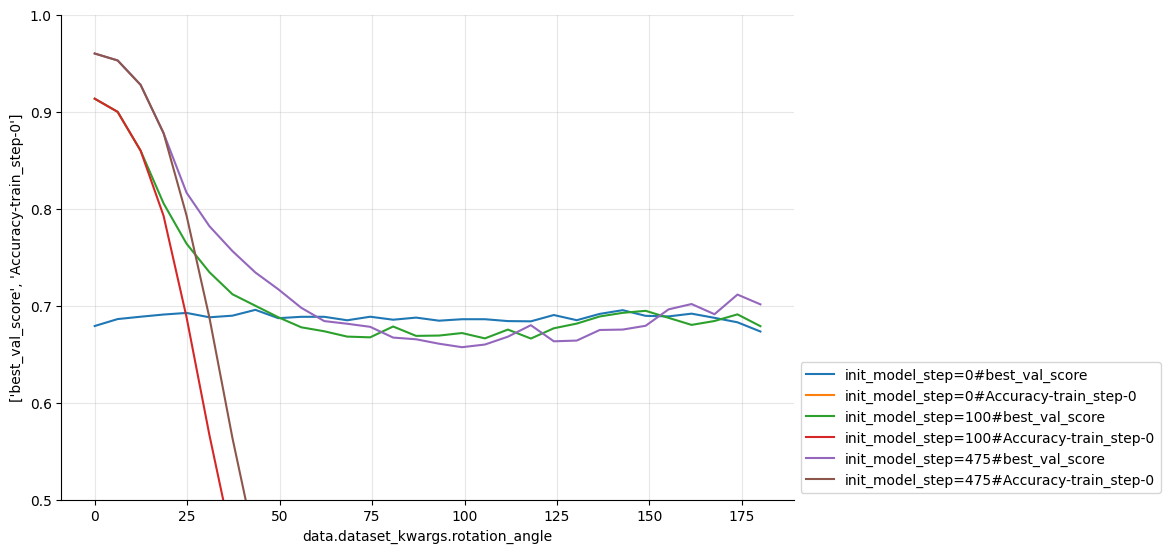

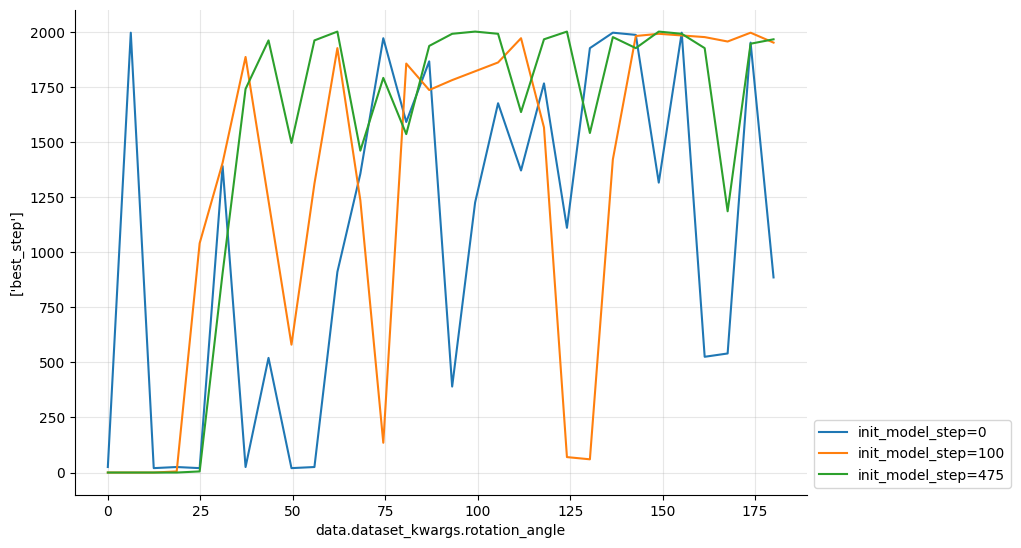

In [23]:
p0 = plot_sweep_summary(rot_df, x_axis='data.dataset_kwargs.rotation_angle', y_axis=['best_val_score', 'Accuracy-train_step-0'], compare_parameter='trainer.init_model_step', ylim=[0.5,1.0])
p1 = plot_sweep_summary(rot_df, x_axis='data.dataset_kwargs.rotation_angle', y_axis='best_step', compare_parameter='trainer.init_model_step')

### Pretrain vs. [Acc, best_step]

We finetune a model pretrained on rotation 0° (48k samples) to other rotations 0°-180° (**50** samples).
We use an early stopping patience of 200 steps (max. 2000).

Observations:
- more pretraining -> better final accuracy, even for large distribution shift (confirmed by low-level statistic obervation of neyshabur)
- the larger the distribution shift, the more fine-tuning steps are performed

In [18]:
compare_rotation_angles = pv_df['data.dataset_kwargs.rotation_angle'].unique()
cpvsel = list(compare_rotation_angles[0:1]) + list(compare_rotation_angles[1:20:3]) + list(compare_rotation_angles[-2::])
# cpvsel = [0., 180.]
cpvsel

[0.0,
 6.206896551724138,
 24.82758620689655,
 43.44827586206897,
 62.06896551724138,
 80.6896551724138,
 99.3103448275862,
 117.93103448275862,
 173.79310344827587,
 180.0]

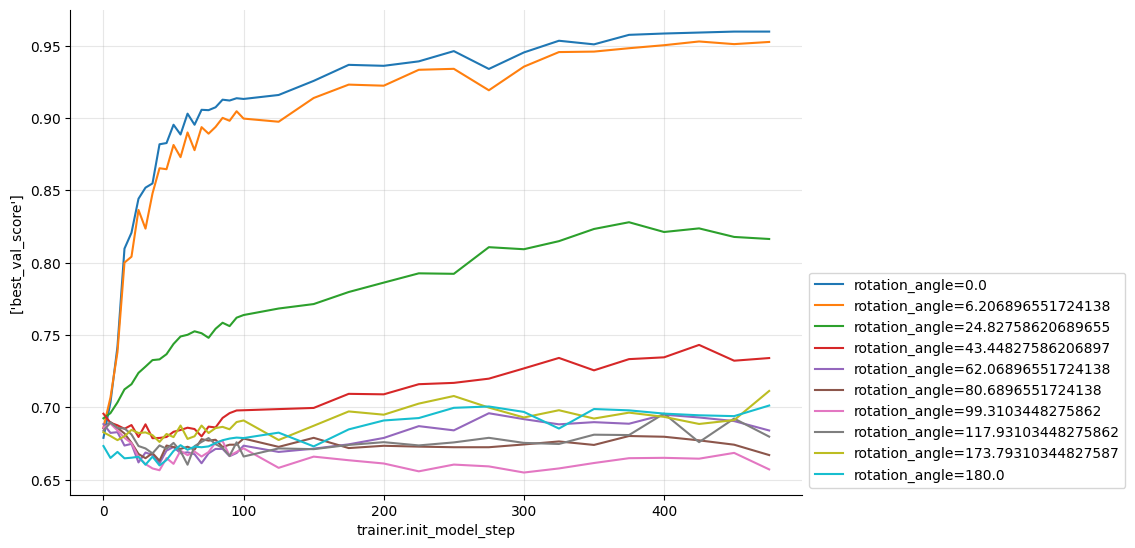

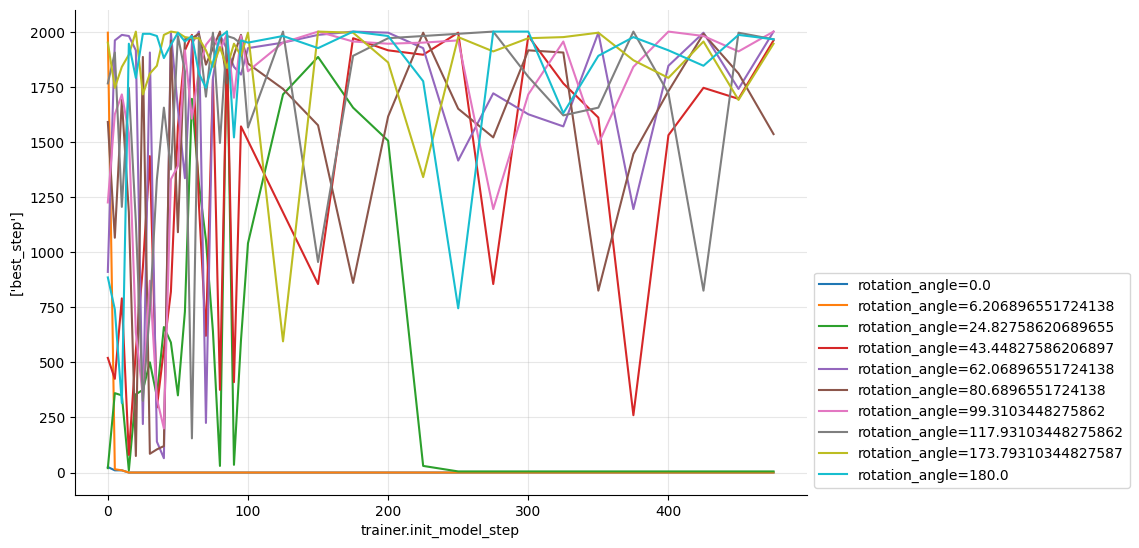

In [19]:
p1 = plot_sweep_summary(pv_df, x_axis='trainer.init_model_step', y_axis='best_val_score', compare_parameter='data.dataset_kwargs.rotation_angle', compare_parameter_val_selection=cpvsel)
# p2 = plot_sweep_summary(pv_df, x_axis='trainer.init_model_step', y_axis='Accuracy-train_step-0', compare_parameter='data.dataset_kwargs.rotation_angle', compare_parameter_val_selection=cpvsel)
p3 = plot_sweep_summary(pv_df, x_axis='trainer.init_model_step', y_axis='best_step', compare_parameter='data.dataset_kwargs.rotation_angle', compare_parameter_val_selection=cpvsel)

### Pretrain vs Acc
solid: best_val_score

dotted: Accuracy of pretrained model on the respective rotation

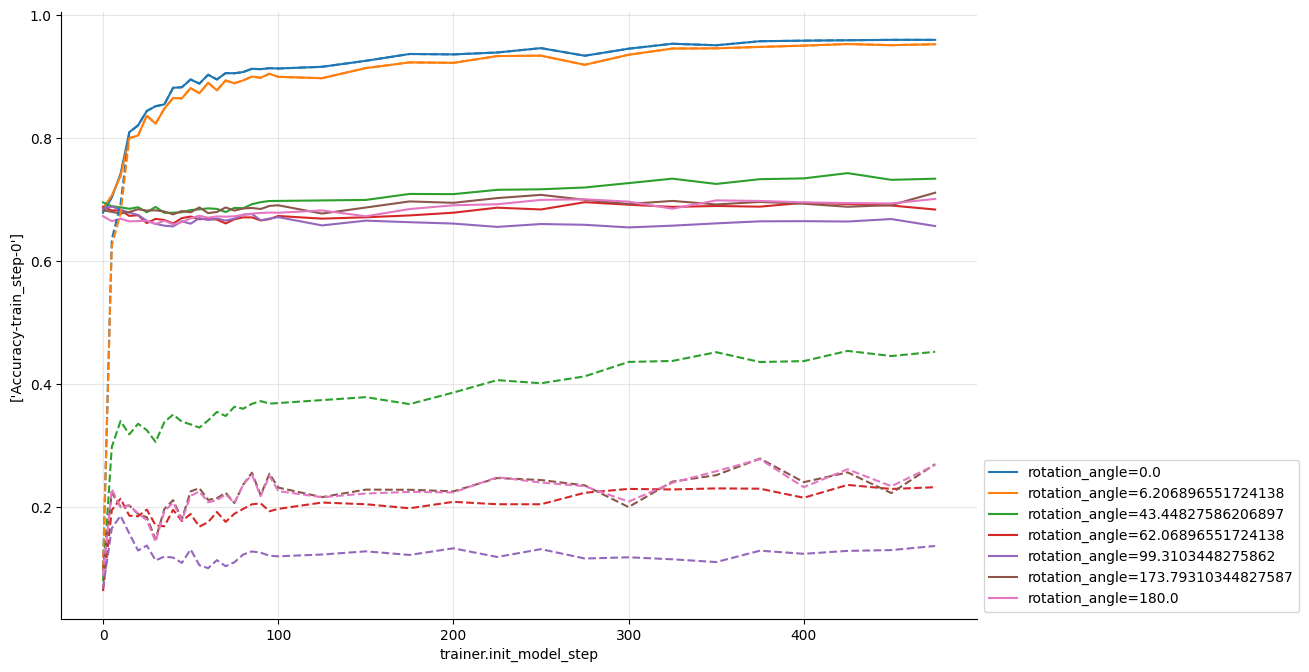

In [20]:
fig, ax = plt.subplots(figsize=(2.5 * 12 * 1 / 2.54, 2.5 * 8 * 1 / 2.54))
cpvsel= [0.0,
 6.206896551724138,
#  24.82758620689655,
 43.44827586206897,
 62.06896551724138,
#  80.6896551724138,
 99.3103448275862,
#  117.93103448275862,
 173.79310344827587,
 180.0]
p1 = plot_sweep_summary(pv_df, ax=ax, x_axis='trainer.init_model_step', y_axis='best_val_score', compare_parameter='data.dataset_kwargs.rotation_angle', compare_parameter_val_selection=cpvsel)
with mpl.rc_context({'lines.linestyle': '--'}):
    ax.set_prop_cycle(None)
    p2 = plot_sweep_summary(pv_df, ax=ax, x_axis='trainer.init_model_step', y_axis='Accuracy-train_step-0', compare_parameter='data.dataset_kwargs.rotation_angle', compare_parameter_val_selection=cpvsel, legend_args={})
# ax.set_ylim(0,0.2)

## C. Linear Mode Connectivity 

In [24]:
print(sweepr)

Exp. Tag(start_num): 11.7(4)
Exp. Name: mnist-11.7.4-lenet_rottasks_ft
Training setup: supervised
Model name: fc
Dataset name: rotatedvision
Sweep type: grid
  trainer.init_model_step: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475]
  data.dataset_kwargs.rotation_angle: linspace(0,180,30,endpoint=True)
  data.dataset_split.restrict_n_samples_train_task: [50]
Num. jobs: 2150
Config updated: 2022-12-12 17:43:28
Sweep started:  2022-12-12 17:42:56

